In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"  # specify which GPU(s) to be used
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import, division, print_function

import argparse
import glob
import logging
import os
import shutil
import random

import numpy as np
import torch
from seqeval.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from tensorboardX import SummaryWriter
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange
from utils_seq_labeling import (
    convert_examples_to_features,
    get_labels,
    read_examples_from_file,
)
from modeling_layoutlm import LayoutLMForTokenClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import (
    WEIGHTS_NAME,
    BertConfig,
    BertForTokenClassification,
    BertTokenizer,
)
from transformers import RobertaConfig, RobertaForTokenClassification, RobertaTokenizer
from transformers import (
    DistilBertConfig,
    DistilBertForTokenClassification,
    DistilBertTokenizer,
)

logger = logging.getLogger(__name__)

ALL_MODELS = sum(
    (
        tuple(conf.pretrained_config_archive_map.keys())
        for conf in (BertConfig, RobertaConfig, DistilBertConfig)
    ),
    (),
)

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "distilbert": (
        DistilBertConfig,
        DistilBertForTokenClassification,
        DistilBertTokenizer,
    ),
    "layoutlm": (BertConfig, LayoutLMForTokenClassification, BertTokenizer),
}

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [3]:
from run_seq_labeling import load_and_cache_examples

In [20]:
parser = argparse.ArgumentParser()

## Required parameters
parser.add_argument(
    "--data_dir",
    default='data',
    type=str,
    required=False,
    help="The input data dir. Should contain the training files for the CoNLL-2003 NER task.",
)
parser.add_argument(
    "--model_type",
    default='layoutlm',
    type=str,
    required=False,
    help="Model type selected in the list: " + ", ".join(MODEL_CLASSES.keys()),
)
parser.add_argument(
    "--model_name_or_path",
    #default='pretrained/layoutlm-base-uncased',
    #default='pretrained/syn_model',
    default='output/checkpoint-3000',
    type=str,
    required=False,
    help="Path to pre-trained model or shortcut name selected in the list: "
    + ", ".join(ALL_MODELS),
)
parser.add_argument(
    "--output_dir",
    default='output',
    type=str,
    required=False,
    help="The output directory where the model predictions and checkpoints will be written.",
)

## Other parameters
parser.add_argument(
    "--labels",
    default="data/labels.txt",
    type=str,
    help="Path to a file containing all labels. If not specified, CoNLL-2003 labels are used.",
)
parser.add_argument(
    "--config_name",
    default="",
    type=str,
    help="Pretrained config name or path if not the same as model_name",
)
parser.add_argument(
    "--tokenizer_name",
    default="",
    type=str,
    help="Pretrained tokenizer name or path if not the same as model_name",
)
parser.add_argument(
    "--cache_dir",
    default="",
    type=str,
    help="Where do you want to store the pre-trained models downloaded from s3",
)
parser.add_argument(
    "--max_seq_length",
    default=512,
    type=int,
    help="The maximum total input sequence length after tokenization. Sequences longer "
    "than this will be truncated, sequences shorter will be padded.",
)
parser.add_argument(
    "--do_lower_case",
    action="store_true",
    default=True,
    help="Set this flag if you are using an uncased model.",
)
parser.add_argument(
    "--per_gpu_eval_batch_size",
    default=16,
    type=int,
    help="Batch size per GPU/CPU for evaluation.",
)
parser.add_argument(
    "--no_cuda", action="store_true",
    help="Avoid using CUDA when available"
)
parser.add_argument(
    "--overwrite_output_dir",
    action="store_true",
    help="Overwrite the content of the output directory",
)
parser.add_argument(
    "--overwrite_cache",
    action="store_true",
    help="Overwrite the cached training and evaluation sets",
)
parser.add_argument(
    "--seed", type=int, default=42, help="random seed for initialization"
)

parser.add_argument(
    "--fp16",
    action="store_true",
    default=True,
    help="Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit",
)
parser.add_argument(
    "--fp16_opt_level",
    type=str,
    default="O1",
    help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
    "See details at https://nvidia.github.io/apex/amp.html",
)
parser.add_argument(
    "--local_rank",
    type=int,
    default=-1,
    help="For distributed training: local_rank",
)
args = parser.parse_args('')

In [21]:
import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [22]:
get_labels(args.labels)

['B-EDUCATION_GROUP',
 'B-EXPERIENCE_GROUP',
 'B-IDENTITY_GROUP',
 'B-INTEREST_GROUP',
 'B-INTRODUCTION_GROUP',
 'B-LANGUAGE_GROUP',
 'B-SKILL_GROUP',
 'B-TITLE_GROUP',
 'E-EDUCATION_GROUP',
 'E-EXPERIENCE_GROUP',
 'E-IDENTITY_GROUP',
 'E-INTEREST_GROUP',
 'E-INTRODUCTION_GROUP',
 'E-LANGUAGE_GROUP',
 'E-SKILL_GROUP',
 'E-TITLE_GROUP',
 'I-EDUCATION_GROUP',
 'I-EXPERIENCE_GROUP',
 'I-IDENTITY_GROUP',
 'I-INTEREST_GROUP',
 'I-INTRODUCTION_GROUP',
 'I-LANGUAGE_GROUP',
 'I-SKILL_GROUP',
 'I-TITLE_GROUP',
 'O',
 'S-EDUCATION_GROUP',
 'S-EXPERIENCE_GROUP',
 'S-IDENTITY_GROUP',
 'S-INTEREST_GROUP',
 'S-INTRODUCTION_GROUP',
 'S-LANGUAGE_GROUP',
 'S-SKILL_GROUP',
 'S-TITLE_GROUP']

In [23]:
# Setup CUDA, GPU & distributed training
if args.local_rank == -1 or args.no_cuda:
    device = torch.device(
        "cuda:0" if torch.cuda.is_available() and not args.no_cuda else "cpu"
    )
    if args.no_cuda:
        args.n_gpu = 0
    else:
        torch.cuda.set_device(device)
        args.n_gpu = torch.cuda.device_count()
        
else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend="nccl")
    args.n_gpu = 1
args.device = device

# Setup logging
logging.basicConfig(
    filename=os.path.join(args.output_dir, "pred.log"),
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
)
logger.warning(
    "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
    args.local_rank,
    device,
    args.n_gpu,
    bool(args.local_rank != -1),
    args.fp16,
)

# Set seed
set_seed(args)

# Prepare CONLL-2003 task
labels = get_labels(args.labels)
num_labels = len(labels)
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

# Load pretrained model and tokenizer
if args.local_rank not in [-1, 0]:
    torch.distributed.barrier()  # Make sure only the first process in distributed training will download model & vocab

args.model_type = args.model_type.lower()
config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
config = config_class.from_pretrained(
    args.config_name if args.config_name else args.model_name_or_path,
    num_labels=num_labels,
    cache_dir=args.cache_dir if args.cache_dir else None,
)
tokenizer = tokenizer_class.from_pretrained(
    args.tokenizer_name if args.tokenizer_name else args.model_name_or_path,
    do_lower_case=args.do_lower_case,
    cache_dir=args.cache_dir if args.cache_dir else None,
)
model = model_class.from_pretrained(
    args.model_name_or_path,
    from_tf=bool(".ckpt" in args.model_name_or_path),
    config=config,
    cache_dir=args.cache_dir if args.cache_dir else None,
)

if args.local_rank == 0:
    torch.distributed.barrier()  # Make sure only the first process in distributed training will download model & vocab

model.to(args.device);

INFO:transformers.configuration_utils:loading configuration file output/checkpoint-3000/config.json
INFO:transformers.configuration_utils:Model config BertConfig {
  "_num_labels": 33,
  "architectures": [
    "LayoutLMForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_2

- ### evaluation

In [24]:
mode="test"

eval_dataset = load_and_cache_examples(
    args, tokenizer, labels, pad_token_label_id, mode=mode
)

args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
# Note that DistributedSampler samples randomly
eval_sampler = (
    SequentialSampler(eval_dataset)
)
eval_dataloader = DataLoader(
    eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size
)

INFO:run_seq_labeling:Saving features into cached file data/cached_test_checkpoint-3000_512


In [25]:
from run_seq_labeling import evaluate

In [26]:
logger.info("Training/evaluation parameters %s", args)

result, predictions = evaluate(
    args, model, tokenizer, labels, pad_token_label_id, mode="test"
)

INFO:__main__:Training/evaluation parameters Namespace(cache_dir='', config_name='', data_dir='data', device=device(type='cuda', index=0), do_lower_case=True, eval_batch_size=16, fp16=True, fp16_opt_level='O1', labels='data/labels.txt', local_rank=-1, max_seq_length=512, model_name_or_path='output/checkpoint-3000', model_type='layoutlm', n_gpu=1, no_cuda=False, output_dir='output', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=16, seed=42, tokenizer_name='')
INFO:run_seq_labeling:Loading features from cached file data/cached_test_checkpoint-3000_512
INFO:run_seq_labeling:***** Running evaluation  *****
INFO:run_seq_labeling:  Num examples = 489
INFO:run_seq_labeling:  Batch size = 16


Evaluating: 100%|██████████| 31/31 [00:08<00:00,  3.67it/s]


INFO:run_seq_labeling:
                    precision    recall  f1-score   support

    IDENTITY_GROUP       0.90      0.89      0.90      1924
   EDUCATION_GROUP       0.82      0.79      0.81      2291
       SKILL_GROUP       0.76      0.83      0.79      3082
  EXPERIENCE_GROUP       0.85      0.76      0.80      7530
    INTEREST_GROUP       0.81      0.75      0.78       720
    LANGUAGE_GROUP       0.80      0.79      0.80       428
       TITLE_GROUP       0.92      0.91      0.91       381
INTRODUCTION_GROUP       0.54      0.90      0.67       219

         micro avg       0.82      0.80      0.81     16575
         macro avg       0.83      0.80      0.81     16575

INFO:run_seq_labeling:***** Eval results  *****
INFO:run_seq_labeling:  f1 = 0.8123717654264279
INFO:run_seq_labeling:  loss = 0.603515749977481
INFO:run_seq_labeling:  precision = 0.8248756218905473
INFO:run_seq_labeling:  recall = 0.8002413273001509


In [11]:
logger.info("Training/evaluation parameters %s", args)

result, predictions = evaluate(
    args, model, tokenizer, labels, pad_token_label_id, mode="test"
)

INFO:__main__:Training/evaluation parameters Namespace(cache_dir='', config_name='', data_dir='data', device=device(type='cuda', index=0), do_lower_case=True, eval_batch_size=16, fp16=True, fp16_opt_level='O1', labels='data/labels.txt', local_rank=-1, max_seq_length=512, model_name_or_path='output/checkpoint-1000', model_type='layoutlm', n_gpu=1, no_cuda=False, output_dir='output', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=16, seed=42, tokenizer_name='')
INFO:run_seq_labeling:Loading features from cached file data/cached_test_checkpoint-1000_512
INFO:run_seq_labeling:***** Running evaluation  *****
INFO:run_seq_labeling:  Num examples = 489
INFO:run_seq_labeling:  Batch size = 16


Evaluating: 100%|██████████| 31/31 [00:08<00:00,  3.46it/s]


INFO:run_seq_labeling:
                    precision    recall  f1-score   support

    IDENTITY_GROUP       0.88      0.88      0.88      1924
   EDUCATION_GROUP       0.80      0.76      0.78      2291
       SKILL_GROUP       0.73      0.82      0.78      3082
  EXPERIENCE_GROUP       0.84      0.78      0.81      7530
    INTEREST_GROUP       0.80      0.75      0.77       720
    LANGUAGE_GROUP       0.77      0.75      0.76       428
       TITLE_GROUP       0.91      0.81      0.86       381
INTRODUCTION_GROUP       0.58      0.74      0.65       219

         micro avg       0.81      0.80      0.80     16575
         macro avg       0.81      0.80      0.80     16575

INFO:run_seq_labeling:***** Eval results  *****
INFO:run_seq_labeling:  f1 = 0.8027877533629557
INFO:run_seq_labeling:  loss = 0.4143898573613936
INFO:run_seq_labeling:  precision = 0.8099858748387889
INFO:run_seq_labeling:  recall = 0.7957164404223228


In [13]:
logger.info("Training/evaluation parameters %s", args)

result, predictions = evaluate(
    args, model, tokenizer, labels, pad_token_label_id, mode="test"
)

INFO:__main__:Training/evaluation parameters Namespace(cache_dir='', config_name='', data_dir='data_xt', device=device(type='cuda', index=0), do_lower_case=True, eval_batch_size=16, fp16=True, fp16_opt_level='O1', labels='data_xt/labels.txt', local_rank=-1, max_seq_length=512, model_name_or_path='pretrained/syn_model', model_type='layoutlm', n_gpu=2, no_cuda=False, output_dir='output', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=8, seed=42, tokenizer_name='')
INFO:run_seq_labeling:Loading features from cached file data_xt/cached_test_syn_model_512
INFO:run_seq_labeling:***** Running evaluation  *****
INFO:run_seq_labeling:  Num examples = 1196
INFO:run_seq_labeling:  Batch size = 16


Evaluating: 100%|██████████| 75/75 [00:14<00:00,  5.12it/s]


INFO:run_seq_labeling:
                    precision    recall  f1-score   support

       SKILL_GROUP       0.91      0.90      0.91      7987
  EXPERIENCE_GROUP       0.94      0.94      0.94     19624
    IDENTITY_GROUP       0.96      0.96      0.96      4987
    INTEREST_GROUP       0.85      0.86      0.85      1705
   EDUCATION_GROUP       0.92      0.93      0.92      5817
    LANGUAGE_GROUP       0.84      0.89      0.87      1039
       TITLE_GROUP       0.86      0.86      0.86       628
INTRODUCTION_GROUP       0.57      0.68      0.62       548

         micro avg       0.92      0.92      0.92     42335
         macro avg       0.92      0.92      0.92     42335

INFO:run_seq_labeling:***** Eval results  *****
INFO:run_seq_labeling:  f1 = 0.9218586125219481
INFO:run_seq_labeling:  loss = 0.4366288814942042
INFO:run_seq_labeling:  precision = 0.9198099896529018
INFO:run_seq_labeling:  recall = 0.9239163812448329


In [14]:
from xtramile.imports import *
from xtramile.vision.ocr.tools import extract_pdf_lines_with_words
from xtramile.vision.utils import to_int, transform_dataturks_box
from xtramile.vision.ocr.pdf_wrapper import PdfItem
from xtramile.vision.draw import show_image, show_images

In [ ]:
doc = extract_pdf_lines_with_words('./1014725-1.pdf')

In [ ]:
doc = extract_pdf_lines_with_words('./1.pdf')

In [16]:
doc = extract_pdf_lines_with_words('./good_parsing_1.pdf')

INFO:pdfminer.pdfdocument:xref found: pos=b'126641'
INFO:pdfminer.pdfdocument:read_xref_from: start=126641, token=/b'xref'
INFO:pdfminer.pdfdocument:xref objects: {1: (None, 125816, 0), 2: (None, 19, 0), 3: (None, 2531, 0), 4: (None, 2552, 0), 5: (None, 125976, 0), 6: (None, 51839, 0), 7: (None, 52013, 0), 8: (None, 126224, 0), 9: (None, 126119, 0), 10: (None, 52033, 0), 11: (None, 64526, 0), 12: (None, 64549, 0), 13: (None, 64740, 0), 14: (None, 65110, 0), 15: (None, 65333, 0), 16: (None, 91753, 0), 17: (None, 91776, 0), 18: (None, 91982, 0), 19: (None, 92519, 0), 20: (None, 92910, 0), 21: (None, 124512, 0), 22: (None, 124535, 0), 23: (None, 124736, 0), 24: (None, 125274, 0), 25: (None, 125664, 0), 26: (None, 125717, 0), 27: (None, 126365, 0), 28: (None, 126462, 0)}
INFO:pdfminer.pdfdocument:trailer: {'Size': 29, 'Root': <PDFObjRef:27>, 'Info': <PDFObjRef:28>, 'ID': [b'\xcb\xef[5\xedeE\x1ai\xca\x03\xf0\xfe\xa3\xedN', b'\xcb\xef[5\xedeE\x1ai\xca\x03\xf0\xfe\xa3\xedN'], 'DocChecksum': /

In [17]:
from xtramile.vision.ocr.tools import validate_bbox, clean_text, extract_pdf_lines_with_words, dump_to_layoutlm_json, bbox_string
from xtramile.vision.factory import BoxesDocumentFactory
from xtramile.vision.visual_lm.tools import to_boxes_document_with_words_tags, seg_buffer, convert, read_examples_from_buffers, get_dataset

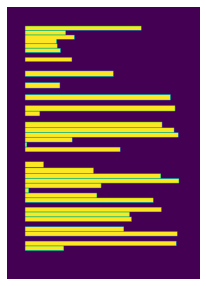

In [18]:
pdf_doc = to_boxes_document_with_words_tags(doc)
pdf_doc.show()

In [19]:
pdf_json = dump_to_layoutlm_json(pdf_doc)

In [20]:
tokenizer, text_buffer, boxes_buffer = convert(pdf_doc, pdf_json, model_name_or_path='pretrained/syn_model')
examples, labels_ = read_examples_from_buffers(text_buffer, boxes_buffer, mode='test')

INFO:transformers.tokenization_utils:Model name 'pretrained/syn_model' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, bert-base-finnish-cased-v1, bert-base-finnish-uncased-v1, bert-base-dutch-cased). Assuming 'pretrained/syn_model' is a path, a model identifier, or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file pretrained/syn_model/added_tokens.json. We won't load it.
INFO:transformers.tokenization_utils:loading file pretrained/syn_model/vocab.txt
INFO:transformers.tokenization_utils:loading 

In [22]:
dataset = get_dataset(args.model_type, tokenizer, examples, labels_, pad_token_label_id)

In [23]:
from xtramile.vision.visual_lm.tools import pred

In [24]:
labels = get_labels('./data_xt/labels.txt')
predictions, boxes = pred(args, model, dataset, labels, pad_token_label_id)

Evaluating: 100%|██████████| 1/1 [00:00<00:00, 34.00it/s]


In [25]:
from xtramile.vision.core import BoundingBoxFigure, BoxesDocument

In [26]:
lbs = list(set([l[l.index('-')+1:] if '-' in l else 'OTHER_GROUP' for l in labels]))

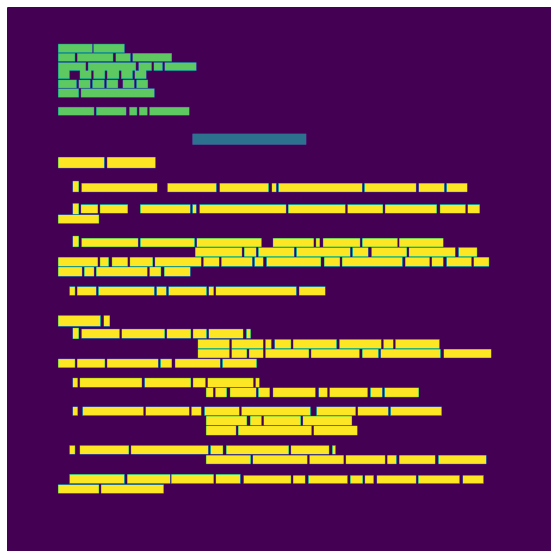

In [28]:
figs = []

for idx in range(len(predictions)):
    bxs = boxes[idx]
    # bxs = examples[idx].boxes

    for p, b in zip(predictions[idx], bxs):
        p = p[p.index('-')+1:] if '-' in p else 'OTHER_GROUP'
        figs.append(BoundingBoxFigure(label=p, box=b, text=p))
    
BoxesDocument(figs, size=(1000, 1000), classes=lbs).show(figsize=(12, 10), show_labels=False)